In [1]:
# take a look of the data

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import libpysal as lps


In [79]:
# read zipfile
df = pd.read_csv('data/data_selection_17_23.csv')

In [6]:
df

,timestamp,nodeid,temperature,humidity,voltage,light
0,1468800,1,NaN,NaN,NaN,NaN
1,1468800,2,NaN,NaN,NaN,NaN
2,1468800,3,NaN,NaN,NaN,NaN
3,1468800,4,NaN,NaN,NaN,NaN
4,1468800,5,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
933115,1987170,50,NaN,NaN,NaN,NaN
933116,1987170,51,NaN,NaN,NaN,NaN
933117,1987170,52,NaN,NaN,NaN,NaN
933118,1987170,53,NaN,NaN,NaN,NaN


In [80]:
# change the timestamp to datetime
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')

In [ ]:
# select the first 2 days data
# df = df[df['datetime'] < '1970-01-19']

In [81]:
# drop nan values
df_clean = df.dropna()
df_clean.shape

(184565, 7)

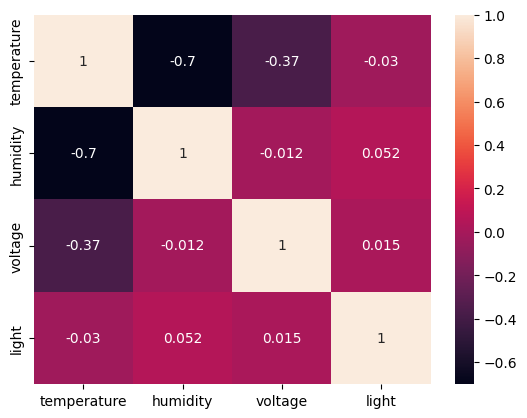

In [10]:
sns.heatmap(df_clean[['temperature','humidity','voltage','light']].corr(method='pearson'), annot=True)
plt.show()

In [99]:
# calculate the correlation between temperature and humidity for each node
correlation = df_clean.groupby('nodeid')[['humidity','voltage']].corr().iloc[0::2,-1].reset_index()


<Axes: xlabel='nodeid', ylabel='voltage'>

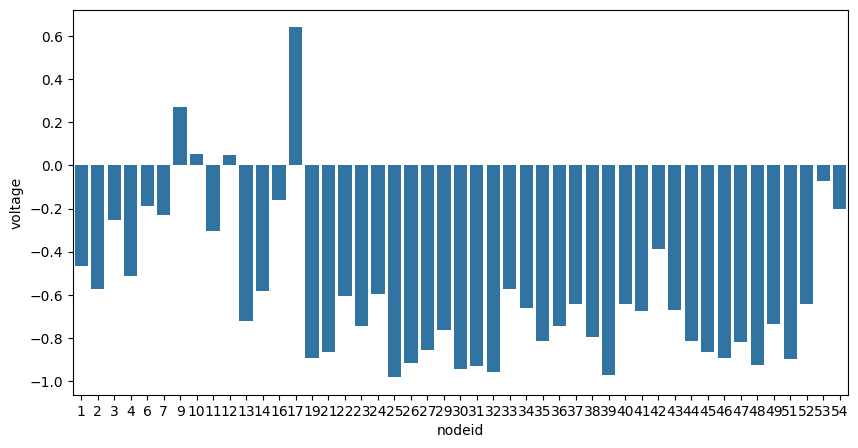

In [100]:
# plot the correlation 
plt.figure(figsize=(10,5))
sns.barplot(x='nodeid', y='voltage', data=correlation)
# the x-axis is nodeid, tilt the x-axis
# plt.xticks(rotation=45)

In [101]:
# rank humidity from high to low
correlation = correlation.sort_values(by='voltage', ascending=False)
correlation[['nodeid','voltage']]

,nodeid,voltage
13,17,0.641352
6,9,0.270419
7,10,0.052988
9,12,0.049932
45,53,-0.073646
12,16,-0.162247
4,6,-0.186004
46,54,-0.201698
5,7,-0.230085
2,3,-0.251404


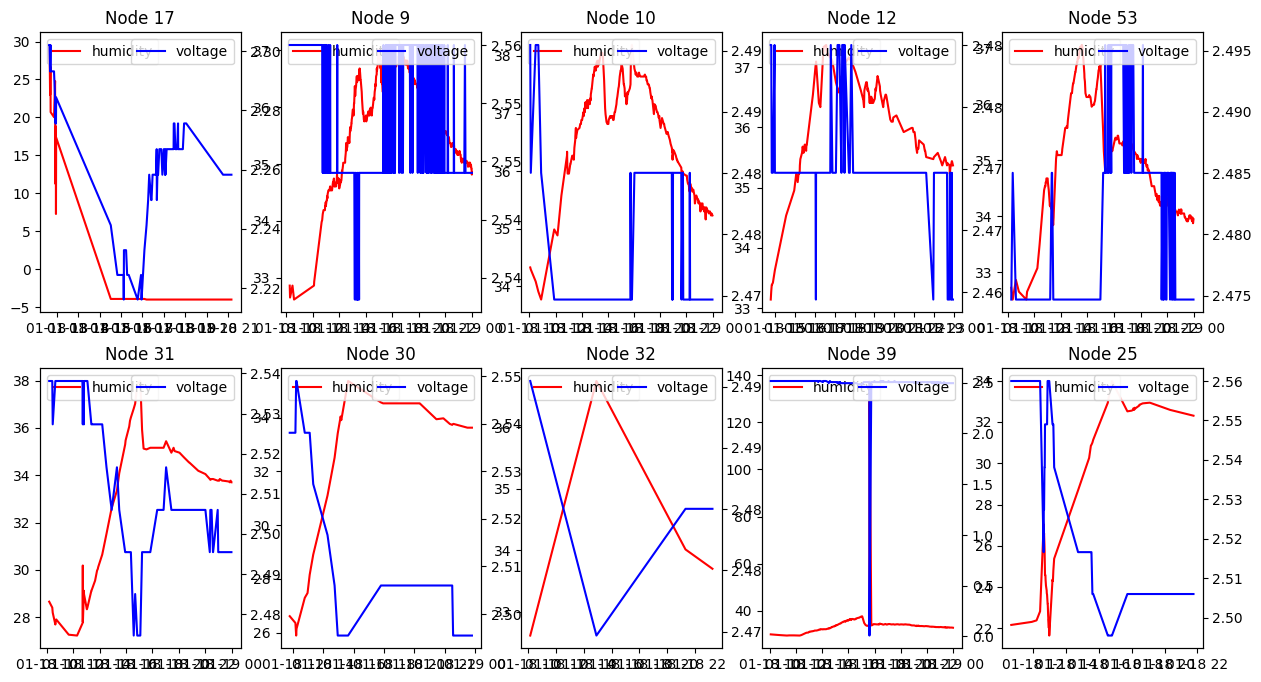

In [104]:
# plot the temperature and humidity for each node
plt.figure(figsize=(15,8))
idx=0
list_to_plot = correlation['nodeid'].values[:5].tolist()+correlation['nodeid'].values[-5:].tolist()
for i in correlation['nodeid'].values[:5].tolist()+correlation['nodeid'].values[-5:].tolist():
    idx=idx+1

    plt.subplot(2, 5, idx)
    data=df_clean[df_clean['nodeid']==i]
    plt.plot(data['datetime'],data['humidity'],label='humidity',color='r')
    plt.legend(loc='upper left')
    # plot the voltage on 2nd y-axis
    plt.twinx()
    plt.plot(data['datetime'],data['voltage'],label='voltage',color='b')
    plt.title('Node '+str(i))
    plt.legend(loc='upper right')
    plt.xticks(rotation=45)

In [69]:
# get location of the sensors
position_data = pd.read_csv('./data/labapp3-positions.txt', sep=' ', names=['nodeid','x','y'])
position_data.set_index('nodeid', inplace=True)
# create a distance matrix
from scipy.spatial.distance import pdist, squareform
position=np.array(position_data)
distance=squareform(pdist(position))

# similarity matrix
similarity=np.exp(-distance**2/(2*100))
# normalize the similarity matrix using Laplacian normalization
D=np.diag(np.sum(similarity,axis=1))
L=D-similarity
D_inv=np.linalg.inv(D)
D_inv_sqrt=np.sqrt(D_inv)
L_norm=D_inv_sqrt@L@D_inv_sqrt




(12, 7)


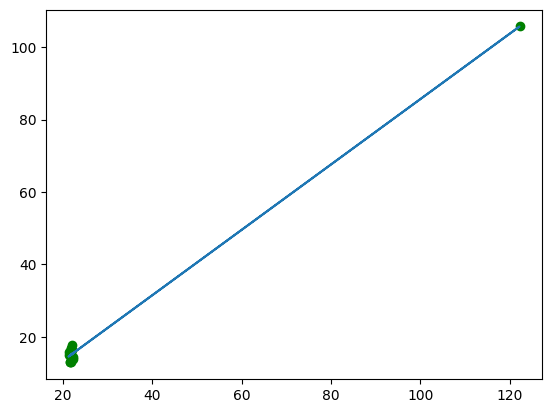

In [83]:
# select the first timestamp
one_ts=df_clean[df_clean['timestamp']== df_clean['timestamp'].iloc[20000]]
print(one_ts.shape)
# select the ids of the sensors based on one_ts.nodeid
ids=one_ts['nodeid'].values-1
one_ts_similarity=L_norm[ids][:,ids]
# turn similarity into a spatial weights matrix scipy.sparse
sparse_similarity=lps.weights.util.full2W(one_ts_similarity)
y= one_ts['temperature']
ylag=lps.weights.lag_spatial(sparse_similarity,y)
plt.plot(y,ylag,'go')
try:
    b, a = np.polyfit(y, ylag, 1)
    plt.plot(y, a + b*y, label='temperature')
except Exception as e:
    print(e)
